# Tutorial: Train a room occupancy prediction model, export it in ONNX format and score with ADX

Open dataset from UCI Repository: __[Occupancy Detection](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)__

Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2.
Ground-truth occupancy was obtained from time stamped pictures that were taken every minute


## Prerequisite

* Enable Python plugin on your ADX cluster (see the Onboarding section of the __[python() plugin doc](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/query/pythonplugin?pivots=azuredataexplorer)__)
* Whitelist a blob container to be accessible by ADX Python sandbox (see the Appendix section of the doc)
* Create a local Python environment (conda or virtual env) that reflects the Python sandbox image
* Install in that environment ONNX packages: onnxruntime and skl2onnx packages
* Install in that environment Azure Blob Storage package: azure-storage-blob

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Fetch the occupancy detection dataset from Kusto using __[KqlMagic](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic)__

* Display some records

In [1]:
#!pip install Kqlmagic -q --no-cache-dir --upgrade

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


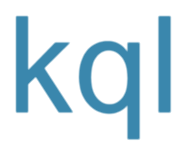

In [2]:
reload_ext Kqlmagic

In [3]:
%config Kqlmagic.auto_dataframe = True

### Retrieving the table for classification from Kusto

In [4]:
%kql kusto://code;cluster='demo11.westus';database='ML' -try_azcli_login

<IPython.core.display.Javascript object>

In [5]:
%kql df << OccupancyDetection

In [6]:
print(df.shape, "\n")
df[:4]

(20560, 8) 



,Timestamp,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Test
0,2015-02-04 17:51:00+00:00,23.18,27.2720,426.0,721.25,0.004793,True,False
1,2015-02-04 17:51:00+00:00,23.15,27.2675,429.5,714.00,0.004783,True,False
2,2015-02-04 17:53:00+00:00,23.15,27.2450,426.0,713.50,0.004779,True,False
3,2015-02-04 17:54:00+00:00,23.15,27.2000,426.0,708.25,0.004772,True,False


In [7]:
# Convert label column (Occupancy) from binary to string, currently skl2onnx conversion doesn't support binary labels

df.Occupancy = df.Occupancy.astype(str)

## Train Model

Split the data to features (x), labels (y) and for training/testing

In [8]:
train_x = df[df['Test'] == False][['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
train_y = df[df['Test'] == False]['Occupancy']
test_x = df[df['Test'] == True][['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
test_y = df[df['Test'] == True]['Occupancy']

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(8143, 5) (8143,) (12417, 5) (12417,)


Train few classic models from Scikit-learn

In [ ]:
from sklearn import tree
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#four classifier types
clf1 = tree.DecisionTreeClassifier()
clf2 = LogisticRegression(solver='liblinear')
clf3 = neighbors.KNeighborsClassifier()
clf4 = naive_bayes.GaussianNB()

In [10]:
clf1 = clf1.fit(train_x, train_y)
clf2 = clf2.fit(train_x, train_y)
clf3 = clf3.fit(train_x, train_y)
clf4 = clf4.fit(train_x, train_y)

Accuracy on Training set

In [11]:
for clf, label in zip([clf1, clf2, clf3, clf4], ['Decision Tree', 'Logistic Regression', 'K Nearest Neighbour', 'Naive Bayes']):
            scores = cross_val_score(clf, train_x, train_y, cv=5, scoring='accuracy')
            print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.9247 (+/- 0.0648) [Decision Tree]
Accuracy: 0.9862 (+/- 0.0140) [Logistic Regression]
Accuracy: 0.9503 (+/- 0.0555) [K Nearest Neighbour]
Accuracy: 0.9635 (+/- 0.0268) [Naive Bayes]


Accuracy on Testing set

In [12]:
for clf, label in zip([clf1, clf2, clf3, clf4], ['Decision Tree', 'Logistic Regression', 'K Nearest Neighbour', 'Naive Bayes']):
            scores = cross_val_score(clf, test_x, test_y, cv=5, scoring='accuracy')
            print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.8556 (+/- 0.1195) [Decision Tree]
Accuracy: 0.9887 (+/- 0.0071) [Logistic Regression]
Accuracy: 0.9656 (+/- 0.0223) [K Nearest Neighbour]
Accuracy: 0.8893 (+/- 0.1265) [Naive Bayes]


The logistic regression model is the best one

## Convert the model to ONNX

In [13]:
import skl2onnx
skl2onnx.__version__

C:\Python\envs\tmp\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



'1.7.0'

In [14]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

### We define the input type (5 sensors readings), convert the scikit-learn model to ONNX and serialize it

In [15]:
initial_type = [('float_input', FloatTensorType([None, 5]))]
onnx_model = convert_sklearn(clf2, initial_types=initial_type)
bmodel = onnx_model.SerializeToString()

## Test ONNX Model

Predict using ONNX runtime

In [16]:
import numpy as np
import onnxruntime as rt

rt.__version__

'1.4.0'

In [17]:
sess = rt.InferenceSession(bmodel)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onnx = sess.run([label_name], {input_name: test_x.values.astype(np.float32)})[0]

Verify ONNX and Scikit-learn predictions are same

In [18]:
pred_clf2 = clf2.predict(test_x)

diff_num = (pred_onnx != pred_clf2).sum()

if diff_num:
    print(f'Predictions difference between sklearn and onnxruntime, total {diff_num} elements differ')
else:
    print('Same prediction using sklearn and onnxruntime')

Same prediction using sklearn and onnxruntime


## Scoring in ADX using the python() plugin

### Prerequisite

The Python image of ADX sandbox does NOT include ONNX runtime package. Therefore we need to zip and upload it to a blob container and dynamically install from that container. Note that the blob container should be whitelisted to be accessible by ADX Python sandbox (see the appendix section of the __[python() plugin doc](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/query/pythonplugin?pivots=azuredataexplorer)__)

Here are the steps to create and upload the ONNX runtime package:
1. Open Anaconda prompt on your local Python environment
1. Download the onnxruntime package, run:

pip wheel onnxruntime
    
1. Zip all the wheel files into onnxruntime-1.4.0-py36.zip (or your preferred name)
1. Upload the zip file to a blob in the whitelisted blob container (you can use Azure Storage Explorer)
1. Generate a SAS key with read permission to the blob

### Scoring

2 options for retrieving the model for scoring:
- serialize the model to a string to be stored in a standard table in ADX
- copy the model to a blob container (that was previously whitelisted for access by ADX Python sandbox)

### Scoring from serialized model which is stored in ADX table

Serializing the model and store it in ADX models table using KqlMagic

In [19]:
import pandas as pd
import datetime

models_tbl = 'ML_Models'
model_name = 'ONNX-Occupancy'

smodel = bmodel.hex()
now = datetime.datetime.now()
dfm = pd.DataFrame({'name':[model_name], 'timestamp':[now], 'model':[smodel]})
dfm

,name,timestamp,model
0,ONNX-Occupancy,2020-07-29 10:19:47.430332,08031208736b6c326f6e6e781a05312e372e3022076169...


In [20]:
set_query = '''
.set-or-append {0} <|
let tbl = dfm;
tbl
'''.format(models_tbl)
print(set_query)


.set-or-append ML_Models <|
let tbl = dfm;
tbl



In [21]:
%kql -query set_query

,ExtentId,OriginalSize,ExtentSize,CompressedSize,IndexSize,RowCount
0,ff80423c-88f0-469d-8355-4a78ae105c27,1426.0,1498.0,1048.0,450.0,1


Scoring from serialized model which is stored in ADX table

In [1]:
# NOTE: we run ADX scoring query here using KqlMagic by embedding the query from Kusto Explorer
# with r'''Kusto Explorer query''':

# NOTE: replace the string "**** YOUR SAS KEY ****" in the external_artifacts parameter with the real SAS

scoring_from_table_query = r'''
let classify_sf=(samples:(*), models_tbl:(name:string, timestamp:datetime, model:string), model_name:string, features_cols:dynamic, pred_col:string)
{
    let model_str = toscalar(models_tbl | where name == model_name | top 1 by timestamp desc | project model);
    let kwargs = pack('smodel', model_str, 'features_cols', features_cols, 'pred_col', pred_col);
    let code =
    '\n'
    'import pickle\n'
    'import binascii\n'
    '\n'
    'smodel = kargs["smodel"]\n'
    'features_cols = kargs["features_cols"]\n'
    'pred_col = kargs["pred_col"]\n'
    'bmodel = binascii.unhexlify(smodel)\n'
    '\n'
    'from sandbox_utils import Zipackage\n'
    'Zipackage.install("onnxruntime.zip")\n'
    'features_cols = kargs["features_cols"]\n'
    'pred_col = kargs["pred_col"]\n'
    '\n'
    'import onnxruntime as rt\n'
    'sess = rt.InferenceSession(bmodel)\n'
    'input_name = sess.get_inputs()[0].name\n'
    'label_name = sess.get_outputs()[0].name\n'
    'df1 = df[features_cols]\n'
    'predictions = sess.run([label_name], {input_name: df1.values.astype(np.float32)})[0]\n'
    '\n'
    'result = df\n'
    'result[pred_col] = pd.DataFrame(predictions, columns=[pred_col])'
    '\n'
    ;
    samples | evaluate python(typeof(*), code, kwargs,
        external_artifacts=pack('onnxruntime.zip', 'https://artifcatswestus.blob.core.windows.net/kusto/ONNX/onnxruntime-1.4.0-py36.zip?**** YOUR SAS KEY ****')
)
};
OccupancyDetection 
| where Test == 1
| extend pred_Occupancy=bool(0)
| invoke classify_sf(ML_Models, 'ONNX-Occupancy', pack_array('Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'), 'pred_Occupancy')
'''

In [23]:
%kql pred_df << -query scoring_from_table_query
pred_df[-4:]

,Timestamp,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Test,pred_Occupancy
12413,2015-02-18 09:16:00+00:00,20.865,27.7450,423.50,1514.5,0.004230,True,True,True
12414,2015-02-18 09:16:00+00:00,20.890,27.7450,423.50,1521.5,0.004237,True,True,True
12415,2015-02-18 09:17:00+00:00,20.890,28.0225,418.75,1632.0,0.004279,True,True,True
12416,2015-02-18 09:19:00+00:00,21.000,28.1000,409.00,1864.0,0.004321,True,True,True


In [24]:
print('Confusion Matrix')
pred_df.groupby(['Occupancy', 'pred_Occupancy']).size()

Confusion Matrix


Occupancy  pred_Occupancy
False      False             9284
           True               112
True       False               15
           True              3006
dtype: int64

### Scoring from model which is stored in blob storage

Copy the model to blob

Note again that the blob container should be whitelisted to be accessible by ADX Python sandbox (see the appendix section of the __[python() plugin doc](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/query/pythonplugin?pivots=azuredataexplorer)__)

In [25]:
# Endpoint & SAS of kusto container
# NOTE: replace the string "**** YOUR SAS KEY ****" in the external_artifacts parameter with the real SAS

from azure.storage.blob import BlobClient

conn_str = "BlobEndpoint=https://artifcatswestus.blob.core.windows.net/kusto;SharedAccessSignature=**** YOUR SAS KEY ****"
blob_client = BlobClient.from_connection_string(conn_str, container_name="ONNX", blob_name="room_occupancy.onnx")

res = blob_client.upload_blob(bmodel, overwrite=True)
res["error_code"]

In [2]:
# NOTE: we run ADX scoring query here using KqlMagic by embedding the query from Kusto Explorer
# with r'''Kusto Explorer query''':

# NOTE: replace the strings "**** YOUR SAS KEY ****" below with the respective real SAS

scoring_from_blob_query = r'''
let classify_sf=(samples:(*), model_sas:string, features_cols:dynamic, pred_col:string)
{
    let kwargs = pack('features_cols', features_cols, 'pred_col', pred_col);
    let code =
    '\n'
    'from sandbox_utils import Zipackage\n'
    'Zipackage.install("onnxruntime.zip")\n'
    'features_cols = kargs["features_cols"]\n'
    'pred_col = kargs["pred_col"]\n'
    '\n'
    'import onnxruntime as rt\n'
    'sess = rt.InferenceSession(r"C:\\Temp\\model.onnx")\n'
    'input_name = sess.get_inputs()[0].name\n'
    'label_name = sess.get_outputs()[0].name\n'
    'df1 = df[features_cols]\n'
    'predictions = sess.run([label_name], {input_name: df1.values.astype(np.float32)})[0]\n'
    '\n'
    'result = df\n'
    'result[pred_col] = pd.DataFrame(predictions, columns=[pred_col])'
    '\n'
    ;
    samples | evaluate python(typeof(*), code, kwargs,
        external_artifacts=pack('model.onnx', model_sas,
                                'onnxruntime.zip', 'https://artifcatswestus.blob.core.windows.net/kusto/ONNX/onnxruntime-1.4.0-py36.zip?**** YOUR SAS KEY ****')
)
};
OccupancyDetection 
| where Test == 1
| extend pred_Occupancy=bool(0)
| invoke classify_sf('https://artifcatswestus.blob.core.windows.net/kusto/ONNX/room_occupancy.onnx?**** YOUR SAS KEY ****',
                     pack_array('Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'), 'pred_Occupancy')
'''

In [27]:
%kql pred_df << -query scoring_from_blob_query
pred_df[-4:]

,Timestamp,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Test,pred_Occupancy
12413,2015-02-18 09:16:00+00:00,20.865,27.7450,423.50,1514.5,0.004230,True,True,True
12414,2015-02-18 09:16:00+00:00,20.890,27.7450,423.50,1521.5,0.004237,True,True,True
12415,2015-02-18 09:17:00+00:00,20.890,28.0225,418.75,1632.0,0.004279,True,True,True
12416,2015-02-18 09:19:00+00:00,21.000,28.1000,409.00,1864.0,0.004321,True,True,True


In [28]:
print('Confusion Matrix')
pred_df.groupby(['Occupancy', 'pred_Occupancy']).size()

Confusion Matrix


Occupancy  pred_Occupancy
False      False             9284
           True               112
True       False               15
           True              3006
dtype: int64

## Summary

In this tutorial we showed how to train a model in Scikit-learn, convert it to ONNX format and export it to ADX for scoring. This workflow is convenient as
* Training can be done on any hardware platform, using any framework supporting ONNX
* Scoring is done in ADX near the data, on the existing compute nodes, enabling near real time processing of big amounts of new data. There is no the need to export the data to external scoring service and import back the results. Consequently, scoring architecture is simpler and performance is much faster and scalable